# 프로젝트 : 주식 예측에 도전해 보자

## STEP 1 : 시계열 데이터 준비
* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
* 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings  # 경고 메시지(warning message) 숨기기
warnings.filterwarnings('ignore')

In [2]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
1,2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2,2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
3,2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
4,2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [3]:
#index_col=['column_name']으로 설정해주면 'column_name'을 pandas의 DataFrame의 index로
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [4]:
ts = df['Close']  # time series 의 이니셜을 따서 'ts'라고 이름 붙임.
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행
* 결측치 처리
* 로그 변환 - 시간 추이에 따라 분산이 점점 커지고 있는 특성을 보일 경우에는 로그함수로 변환을 해주는 것이 도움이 됨.

In [5]:
#  결측치 유무 확인
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


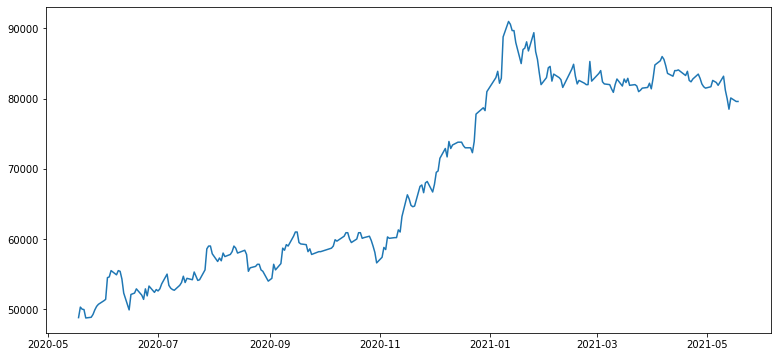

In [6]:
# ****    결측지 없지만 처리 과정 정리  ****

# 결측치가 있다면 이를 보관 - 보관 기준은 time을 선택 
ts=ts.interpolate(method='time')

# 보관 이후 결측치(NaN) 유무를 다시 확인 후
print(ts[ts.isna()])

# 다시 그래프를 확인
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정

plt.plot(ts)

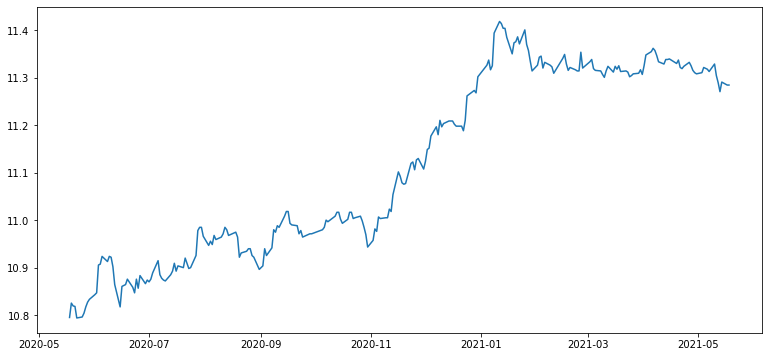

In [7]:
ts_log = np.log(ts)
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

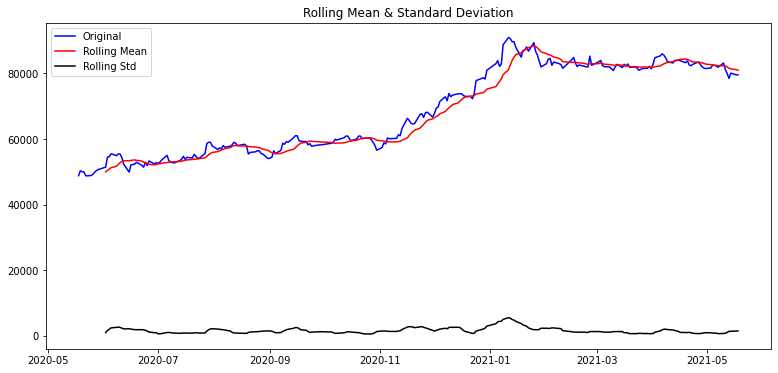

In [8]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수 - 원본 시계열과 함께 시각화해 보면 좀 더 뚜렷한 경향성을 확인 할 수 있음.

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
# 정성적 그래프 분석    
plot_rolling_statistics(ts, window=12)  # 이 데이터셋은 월 단위로 발생하는 시계열이므로 12개월 단위로 주기성이 있기 때문에 window=12 

* 시간의 추이에 따라 평균과 분산이 증가하는 패턴을 보인다면 이 시계열 데이터는 적어도 안정적이진 않다고 정성적인 결론을 내려볼 수 있음

#### Augmented Dickey-Fuller Test

> * 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후,
> * 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에
>* 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택한다.

#### statsmodels 패키지와 adfuller 메서드

tatsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지<br>
statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행 예정.

####  p-value(유의확률)이란
> -value의 정의는 귀무가설을 가정했을 때의 확률분포 상에서 현재의 관측보다 더 극단적인 관측이 나올 확률로서,<br>
> 귀무가설의 가정이 틀렸다고 볼 수 있는 확률이기도 함. <br>
> 이 값이 **0.05 미만으로 매우 낮게 나온다면 p-value만큼의 오류 가능성 하에 귀무가설을 기각하고 대립가설을 채택**할 수 있는 근거가 됨.

In [9]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [10]:
# 정량적 시계열(Time Series)에 대한 Augmented Dickey-Fuller Test를 수행
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


* ts(International airline passengers) 시계열이 안정적이지 않다는 귀무가설은 p-value가 0.66으로 기준인 0.05보다 높게 나타 남.

* p-value가 기준보다 높다는 것은 이 귀무가설("주어진 시계열 데이터가 안정적이지 않다.") 이 옳다는 직접적인 증거는 아님.

* 하지만 이 귀무가설을 기각할 수는 없게 되었으므로 이 시계열이 안정적인 시계열이라고 말할 수는 없슴.

**시계열 분해(Time series decomposition)**<br>
statsmodels 라이브러리 안에는 seasonal_decompose 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능 있슴.<br>
이 기능을 활용하면 우리가 위에서 직접 수행했던 moving average 제거, differencing 등을 거치지 않고도 훨씬 안정적인 시계열을 분리해 낼 수 있게 됨.

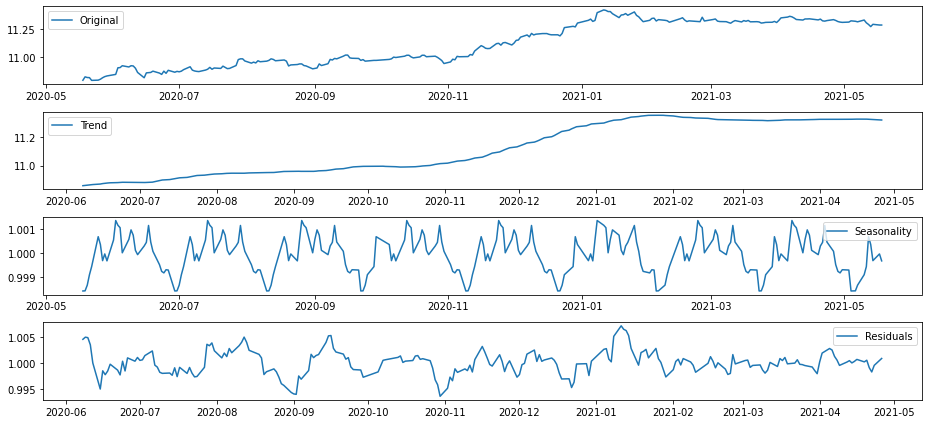

In [11]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [12]:
#  Residual에 대해 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


* Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여 줌.
        확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠음.

## STEP 4 : 학습, 테스트 데이터셋 생성
* 학습, 테스트 데이터셋 분리

시계열 데이터에서 학습 데이터와 테스트 데이터를 분리
> 분리 비율은 학습과 테스트에 9:1 로<br>
> 시계열 예측이니만큼 가장 나중 데이터를 테스트용으로 사용하는 것이 타당.

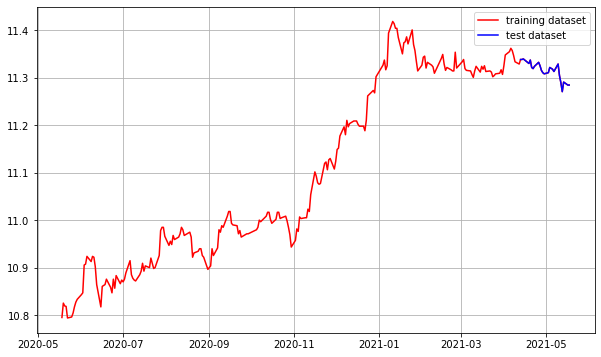

In [13]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용시 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [14]:
# 데이터 셋 형식 확인
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


## STEP 5 : 적정 ARIMA 모수 찾기
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

ARIMA(Autoregressive Integrated Moving Average)를 사용하면 시계열 데이터 예측 모델을 자동으로 만들 수 있음.<br>
**ARIMA는 AR(Autoregressive) + I(Integrated) + MA(Moving Average)**

1. AR(자기회귀, Autoregressive)
    * 자기 자신의 과거를 정보로 사용하는 개념이다. 이는 '현재의 상태는 이전의 상태를 참고해서 계산된다'라는 아이디어를 기본 전제로 한다.
2. MA(이동평균, Moving Average)
    * '이번 항에서의 오차를 이용하여 현재 항의 상태를 추론하자'라는 방법이다.
3. I(차분 누적, Integration)
    * 추세 변동의 경향성 까지 반영한 방법이다.

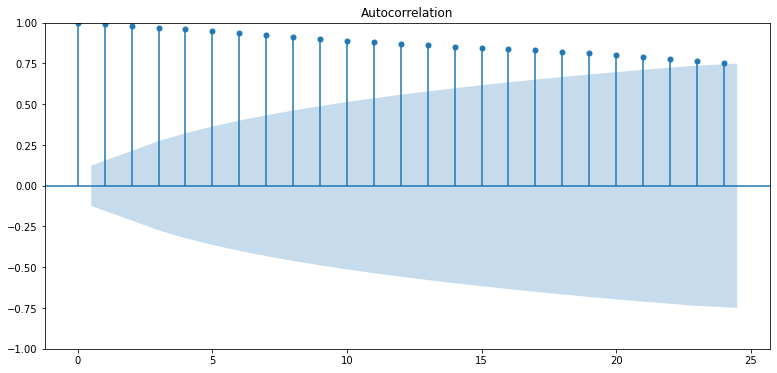

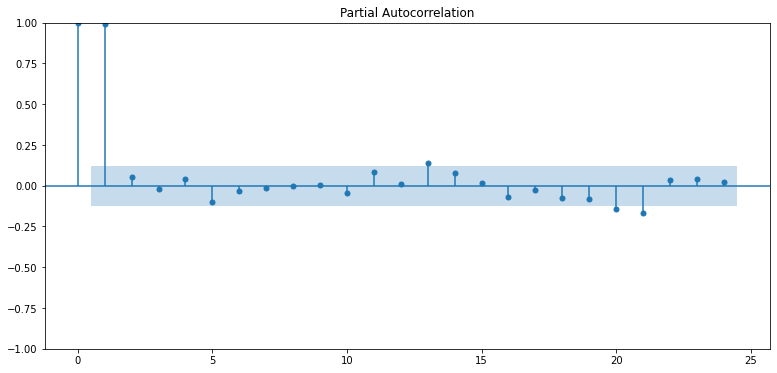

In [15]:
# ACF, PACF 그려보기 -> p,q 구하기

# statsmodels에서 제공하는 ACF와 PACF 플로팅 기능 사용
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

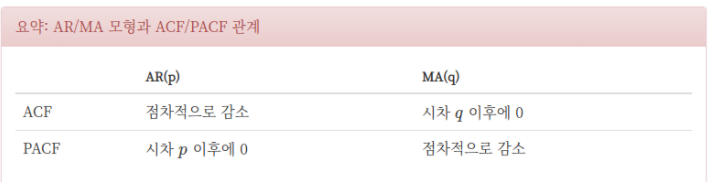
PACF 그래프를 볼 때 p=1이 매우 적합 → p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문
> PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, <br>
>즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻

ACF는 점차적으로 감소하고 있어 q에 대해서는 적합한 값이 없어 보임. MA를 고려할 필요가 없다면 q=0으로 둘 수 있음.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


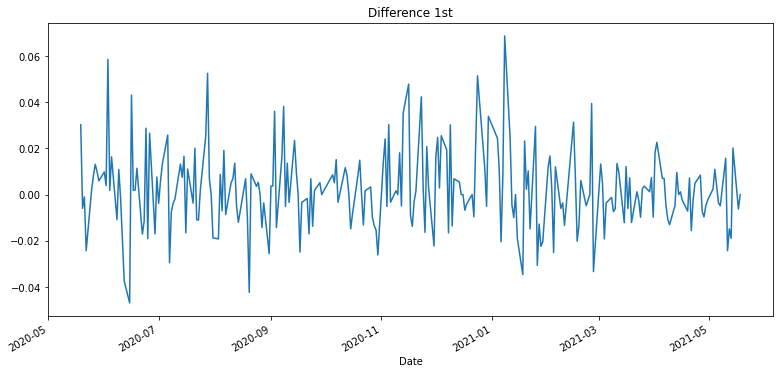

In [16]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


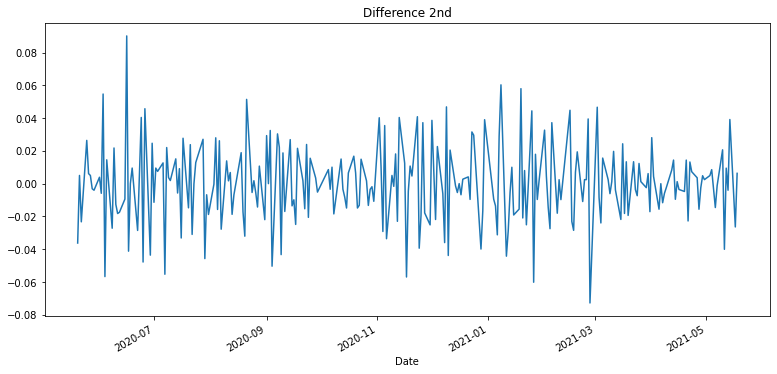

In [17]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

* 1차 차분을 구했을 때보다 2차 차분을 구했을 때는 확실히 안정화 상태, d=2로 먼저 시도
        d 값도 바꿔 가면서 최적의 값을 찾아보기를 권장한다 함

## STEP 6 : ARIMA 모델 훈련과 테스트
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

**ARIMA 클래스에 order=(2,1,2)라고 입력되어진 파라미터의 의미**

* AR이 몇번째 과거까지를 바라보는지에 대한 파라미터 (2) : 과거 값들에 대한 회귀로 미래 값을 예측
* 차분(Defference)에 대한 파라미터(1) : 현재 상태의 변수에서 바로 전 상태의 변수를 빼주는 것을 의미하며, 시계열 데이터의 불규칙성을 조금이나마 보정해주는 역할
* MA가 몇 번째 과거까지를 바라보는지에 대한 파라미터(2) : 최근의 증감 패턴을 지속할 것이라고 보는 관점(이동평균)

In [50]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model

model = ARIMA(train_data, order=(1, 0, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 583.082
Date:                Thu, 10 Feb 2022   AIC                          -1160.164
Time:                        13:52:36   BIC                          -1149.916
Sample:                             0   HQIC                         -1156.028
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.115     96.195      0.000      10.864      11.316
ar.L1          0.9937      0.006    168.571      0.000       0.982       1.005
sigma2         0.0003   2.45e-05     13.135      0.0

* 실행 결과의 표를 살펴보면 계수의 p-value( P>|z| )가 0.05이하로 유의미한 것으로 나타 남.

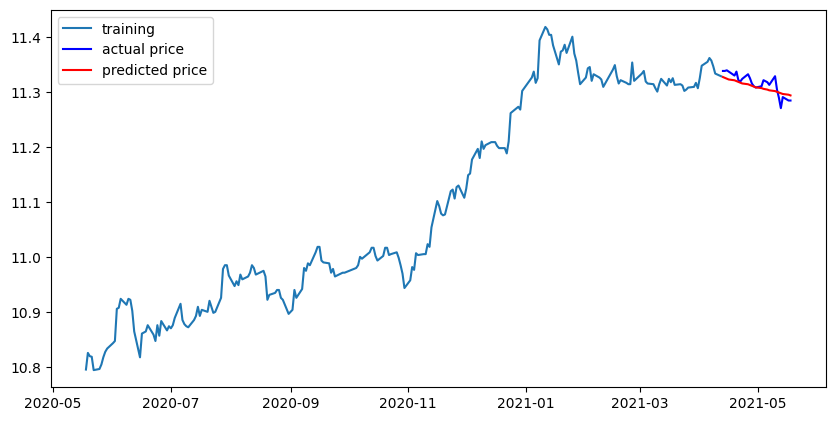

In [51]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse) # MSE 메트릭은 오차 또는 편차의 제곱의 평균을 측정

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae) # 절대 오차의 평균

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)  # RMSE 메트릭은 모델이 연속 값을 얼마나 잘 예측할 수 있는지 평가

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))  #MAPE는 오차의 크기를 백분율로 측정

MSE:  1078734.6873192338
MAE:  866.9125685447763
RMSE:  1038.621532281723
MAPE: 1.05%


모델의 메트릭으로 활용하기에 적당한 MAPE 기준으로 1.03% 정도의 오차율을 보임.
하지만 적당한 모수로 보기엔 ARIMA 클래스에 order=(1, 0, 0)라고 입력되어진 파라미터는 'AR이 몇번째 과거까지를 바라보는지에 대한 파라미터 (1)개만을 사용하는 것으로 부족하게 느껴짐.

## STEP 7 : 다른 주식 종목 예측해 보기
관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

### 시계열 데이터 준비
    야후 주식 데이터 불러오기 - 10년치 SK주가     

In [54]:
!pip install pandas_datareader

     |████████████████████████████████| 109 kB 7.5 MB/s            


In [56]:
!pip install yfinance

  Preparing metadata (setup.py) ... done
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=bf219b5ade2787c8da3553715d39f651184c1f2cd48e56e18b180d468134bba4
  Stored in directory: /aiffel/.cache/pip/wheels/f2/b5/2c/59ba95dcf854e542944c75fe3da584e4e3833b319735a0546c
Successfully built multitasking


In [57]:
from pandas_datareader import data
import datetime
import yfinance as yf
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [58]:
start_date = '2010-01-01'
name = '034730.KS'
stock = data.get_data_yahoo(name, start_date)
stock = stock[:-1]
stock

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,47600.0,44700.0,45300.0,47250.0,416886.0,38969.644531
2010-01-05,49800.0,47350.0,48000.0,49050.0,814484.0,40454.214844
2010-01-06,51300.0,48600.0,49250.0,50000.0,715782.0,41237.726562
2010-01-07,52500.0,49700.0,50000.0,52100.0,718228.0,42969.703125
2010-01-08,58500.0,51000.0,52400.0,55000.0,1098750.0,45361.488281
...,...,...,...,...,...,...
2022-02-03,228000.0,221000.0,222500.0,223500.0,175088.0,223500.000000
2022-02-04,225000.0,220000.0,222500.0,224000.0,130985.0,224000.000000
2022-02-07,224000.0,219000.0,224000.0,223000.0,119763.0,223000.000000


In [61]:
ts_1 = stock['Close']  # 종가(Close)만 사용
print(type(ts_1))
ts_1.head()

<class 'pandas.core.series.Series'>


Date
2010-01-04    47250.0
2010-01-05    49050.0
2010-01-06    50000.0
2010-01-07    52100.0
2010-01-08    55000.0
Name: Close, dtype: float64

### 각종 전처리 수행
* 결측치 처리
* 로그 변환 

In [62]:
#  결측치 유무 확인
ts_1[ts_1.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

* 결측치 없음

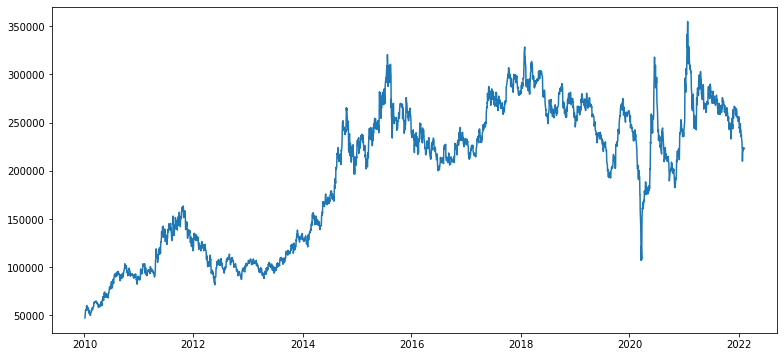

In [65]:
# 그래프로 확인
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정

plt.plot(ts_1)

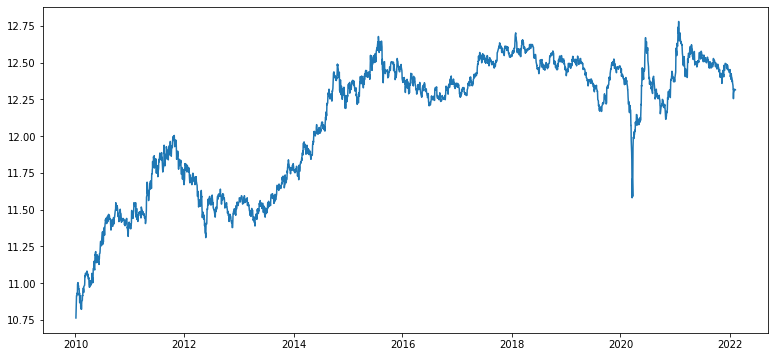

In [66]:
ts_1_log = np.log(ts_1) # 시간 추이에 따라 분산이 점점 커지고 있는 특성을 보일 경우에는 로그함수로 변환을 해주는 것이 도움이 됨.
plt.plot(ts_1_log)

### 시계열 안정성 분석
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

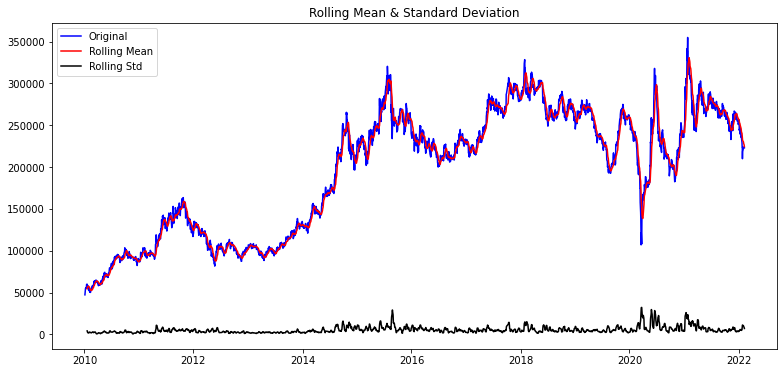

In [67]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수 - 원본 시계열과 함께 시각화해 보면 좀 더 뚜렷한 경향성을 확인 할 수 있음.

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
# 정성적 그래프 분석    
plot_rolling_statistics(ts_1, window=12)   # 월 단위로 발생하는 시계열이므로 12개월 단위로 주기성이 있기 때문에 window=12 

In [68]:
# 정량적 시계열(Time Series)에 대한 Augmented Dickey-Fuller Test를 수행
augmented_dickey_fuller_test(ts_1)

Results of Dickey-Fuller Test:
Test Statistic                   -2.224794
p-value                           0.197370
#Lags Used                        1.000000
Number of Observations Used    2983.000000
Critical Value (1%)              -3.432544
Critical Value (5%)              -2.862509
Critical Value (10%)             -2.567286
dtype: float64


* ts(International airline passengers) 시계열이 안정적이지 않다는 귀무가설은 p-value가 0.197370으로 기준인 0.05보다 높게 나타 남.

* p-value가 기준보다 높다는 것은 이 귀무가설("주어진 시계열 데이터가 안정적이지 않다.") 이 옳다는 직접적인 증거는 아님.

* 하지만 이 귀무가설을 기각할 수는 없게 되었으므로 이 시계열이 안정적인 시계열이라고 말할 수는 없슴.

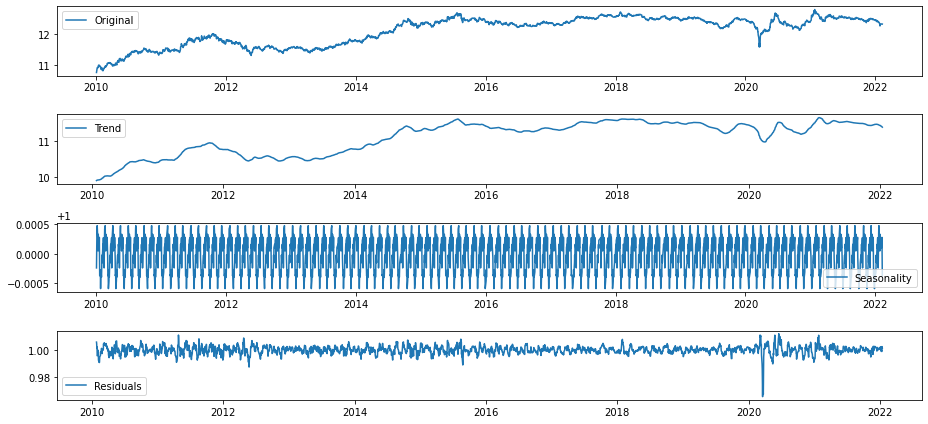

In [71]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_1 = seasonal_decompose(ts_1_log, model='multiplicative', period = 30) 

trend_1 = decomposition_1.trend
seasonal_1 = decomposition_1.seasonal
residual_1 = decomposition_1.resid

plt.subplot(411)
plt.plot(ts_1_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend-1, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_1,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_1, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [72]:
#  Residual에 대해 안정성 확인
residual_1.dropna(inplace=True)
augmented_dickey_fuller_test(residual_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.507879e+01
p-value                        8.513912e-28
#Lags Used                     2.400000e+01
Number of Observations Used    2.930000e+03
Critical Value (1%)           -3.432584e+00
Critical Value (5%)           -2.862527e+00
Critical Value (10%)          -2.567295e+00
dtype: float64


* Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여 줌 - 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠음.

### 학습, 테스트 데이터셋 생성
* 학습, 테스트 데이터셋 분리

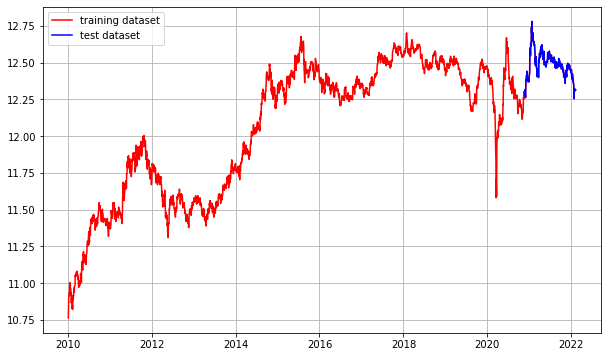

In [75]:
train_1_data, test_1_data = ts_1_log[:int(len(ts_1_log)*0.9)], ts_1_log[int(len(ts_1_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_1_log, c='r', label='training dataset')  # train_data를 적용시 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_1_data, c='b', label='test dataset')
plt.legend()

In [76]:
# 데이터 셋 형식 확인
print(ts_1_log[:2])
print(train_1_data.shape)
print(test_1_data.shape)

Date
2010-01-04    10.763208
2010-01-05    10.800595
Name: Close, dtype: float64
(2686,)
(299,)


### 적정 ARIMA 모수 찾기
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

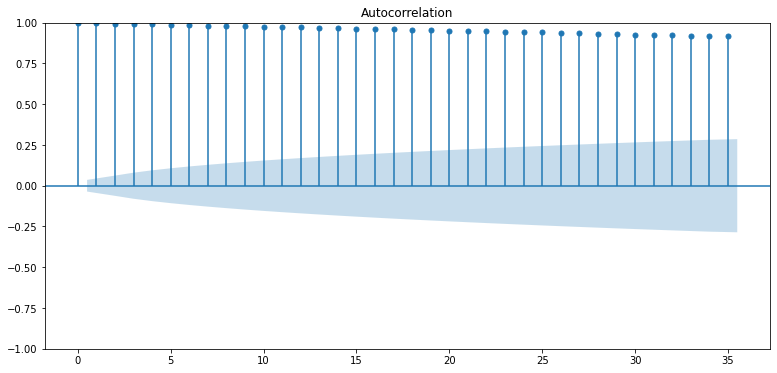

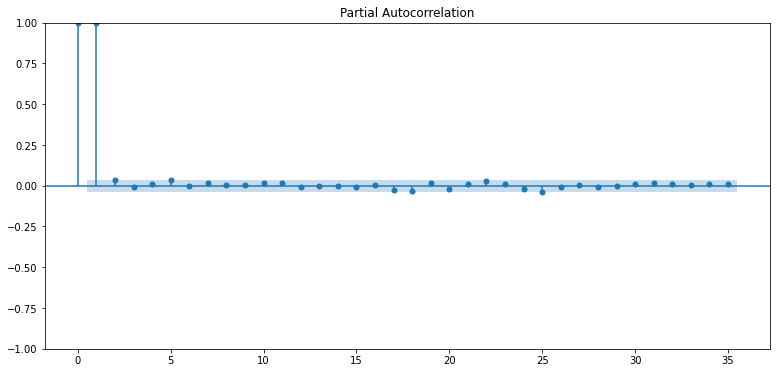

In [77]:
# ACF, PACF 그려보기 -> p,q 구하기

# statsmodels에서 제공하는 ACF와 PACF 플로팅 기능 사용
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_1_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_1_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

PACF 그래프를 볼 때 p=1이 매우 적합 → p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문
> PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, <br>
>즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻

ACF는 점차 조금씩 감소하고 있어나 q에 대해서는 적합한 값이 없어 보임. MA를 고려할 필요가 없다면 q=0으로 둘 수 있음.

Results of Dickey-Fuller Test:
Test Statistic                  -56.459788
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2983.000000
Critical Value (1%)              -3.432544
Critical Value (5%)              -2.862509
Critical Value (10%)             -2.567286
dtype: float64


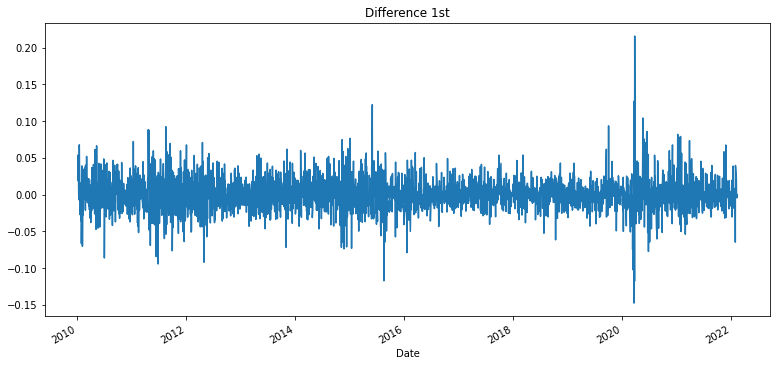

In [78]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1_1 = ts_1_log.diff(periods=1).iloc[1:]
diff_1_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_1)

Results of Dickey-Fuller Test:
Test Statistic                  -56.459788
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2983.000000
Critical Value (1%)              -3.432544
Critical Value (5%)              -2.862509
Critical Value (10%)             -2.567286
dtype: float64


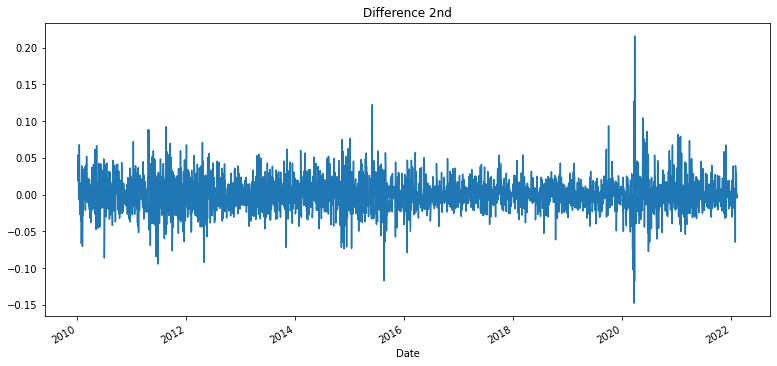

In [80]:
# 2차 차분 구하기
diff_2_1 = ts_1_log.diff(periods=1).iloc[1:]
diff_2_1.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2_1)

* 1차 차분과 2차 차분 차이가 거의 없음....주가 변동이 거의 없는...

### ARIMA 모델 훈련과 테스트
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

In [106]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model

model_1 = ARIMA(train_1_data, order=(3, 2, 1)) # 모수는 이전 그래프를 참고 
fitted_m_1 = model_1.fit() 

print(fitted_m_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2686
Model:                 ARIMA(3, 2, 1)   Log Likelihood                6276.593
Date:                Thu, 10 Feb 2022   AIC                         -12543.187
Time:                        15:21:15   BIC                         -12513.711
Sample:                             0   HQIC                        -12532.524
                               - 2686                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0382      0.012     -3.202      0.001      -0.062      -0.015
ar.L2          0.0296      0.013      2.335      0.020       0.005       0.055
ar.L3          0.0218      0.013      1.628      0.1

* 실행 결과의 표를 살펴보면 계수의 p-value( P>|z| )가 0.05이하로 유의미한 것으로 나타 남. 

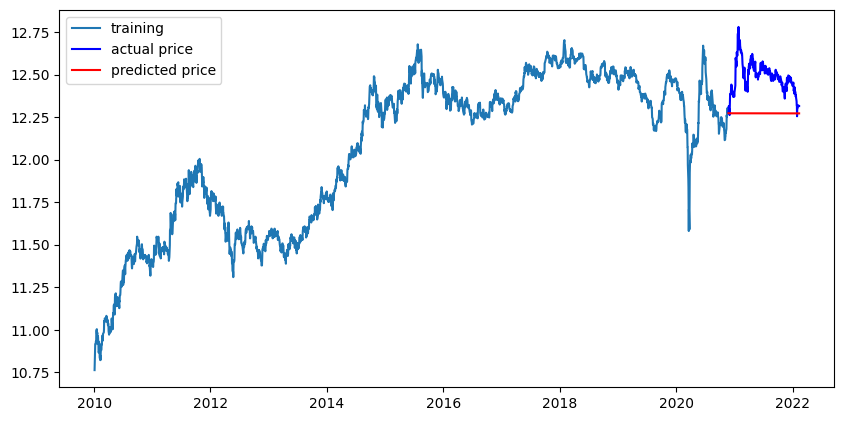

In [107]:
# Forecast : 결과가 fc에 담깁니다. 
fc_1 = fitted_m_1.forecast(len(test_1_data), alpha=0.05)  # 95% conf
fc_1 = np.array(fc_1)
# Make as pandas series
fc_1_series = pd.Series(fc_1, index=test_1_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_1_data, label='training')
plt.plot(test_1_data, c='b', label='actual price')
plt.plot(fc_1_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [108]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse_1 = mean_squared_error(np.exp(test_1_data), np.exp(fc_1))
print('MSE: ', mse_1) # MSE 메트릭은 오차 또는 편차의 제곱의 평균을 측정

mae_1 = mean_absolute_error(np.exp(test_1_data), np.exp(fc_1))
print('MAE: ', mae_1) # 절대 오차의 평균

rmse_1 = math.sqrt(mean_squared_error(np.exp(test_1_data), np.exp(fc_1)))
print('RMSE: ', rmse_1)  # RMSE 메트릭은 모델이 연속 값을 얼마나 잘 예측할 수 있는지 평가

mape_1 = np.mean(np.abs(np.exp(fc_1) - np.exp(test_1_data))/np.abs(np.exp(test_1_data)))
print('MAPE: {:.2f}%'.format(mape_1*100))  #MAPE는 오차의 크기를 백분율로 측정

MSE:  3342025764.460044
MAE:  52758.368032933126
RMSE:  57810.25656801779
MAPE: 19.19%


모델의 메트릭으로 활용하기에 적당한 MAPE 기준으로 19.19% 정도의 오차율을 보임.

##  후기

* 모델의 정확도가 불안전하여 이 것으로 거래를 하는 것은 투자가 아닌 도박일 것 같다.
* 특히 주식 전문가들이 사용하는 프로그램은 단순한 주가 변동외에 기업 재무제표, 외부 환경변화(경영진 사건사고, 환률 변동 등)와 여러 사항들을 반영하여 예측을 하므로 정보가 있는 곳이 우위에 서는 것이 당연해 보인다.
* 모든 자료가 마찮가지로 자료에 대한 이해가 모델의 질을 많이 좌우하는 것 같다.